In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os

import os
import urllib.request
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation
# load libraries

output_dir = "../../LCMS/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

urls = ['https://storage.googleapis.com/abca7lof/LCMS/SUB14737/5041.SUB14737_LipidXData.csv']

for url in urls:
    local_filename = os.path.join(output_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, local_filename)
    print("Download completed!")

Download completed!


In [ ]:
# no background correction made; must consider blanks

In [2]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '2685.SUB15127_LipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 
sample_dictionary = {'s1':'Y+H2O',
                     's2':'E3+H2O',
                     's3':'Y+C',
                     's4':'G2+H2O',
                     'c':'blank'}

palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'blue'
}


In [3]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# remove blanks
areas_no_blank = areas.iloc[:,(areas_columns=='Y+C') | (areas_columns=='Y+H2O')]
names_no_blank = areas_columns[(areas_columns=='Y+C') | (areas_columns=='Y+H2O')]

# get average extraction blank
ext_blank_h20 = areas.iloc[:, areas_columns == 'blank'].mean(axis=1).squeeze() #.iloc[:,0:2]

# remove extraction blank
areas_no_blank_H20_blank_removed = areas_no_blank.subtract(ext_blank_h20, axis=0)

# get compounds to keep based on extraction blanks
keep_h20 = (((areas_no_blank_H20_blank_removed > 0).sum(axis=1))/areas_no_blank_H20_blank_removed.shape[1])>0.5
keep = keep_h20.index[keep_h20]
data_to_keep = areas_no_blank.loc[keep]

# get significant compounds
stats = return_stats(data_to_keep, names_no_blank, 'Y+H2O', 'Y+C', equal_var=True)
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]
# Drop rows where fold change is NaN
stats = stats.dropna(subset=['log2_fold_change'])

stats.shape


(34, 7)

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

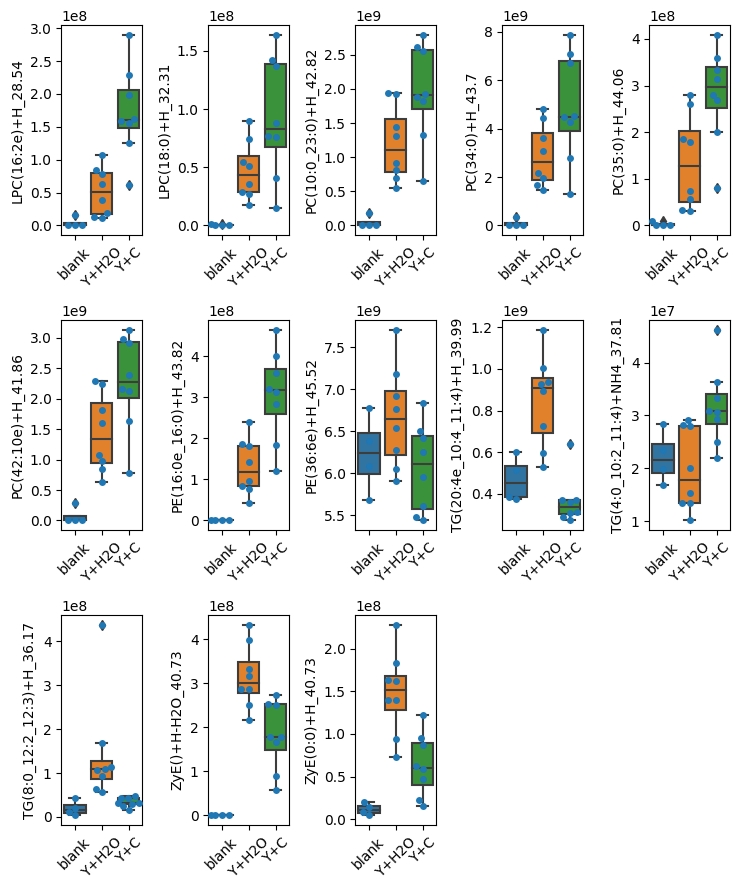

In [4]:
# show sig lipids with blanks
areas_sub = areas.loc[stats[stats['p_value']<0.05].index].iloc[:,(areas_columns=='Y+C') | (areas_columns=='Y+H2O') | (areas_columns=='blank')]
areas_sub.columns = areas_columns[(areas_columns=='Y+H2O') | (areas_columns=='Y+C') | (areas_columns=='blank')]
areas_sub = areas_sub.T
areas_sub['grp'] = areas_sub.index
plot_with_blank(areas_sub)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:54: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['cat'][(data[lfc_col]<0) & (data[pval_col]<0.05)] = 'down'
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:54: SettingWi

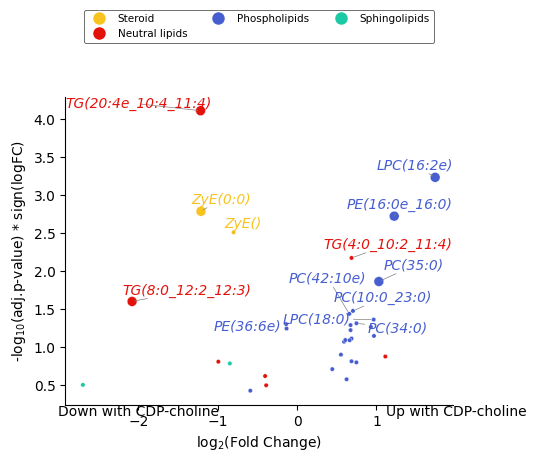

In [15]:
plot_volcano('p_value', 'name', 'grp', 'log2_fold_change', stats, palette)

#plt.ylim(0,2.5)
plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(2,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(2, .1, 'Up with CDP-choline', ha='center', fontsize=10)

plt.annotate('', xy=(-2,0), xytext=(-1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5))
plt.text(-2, .1, 'Down with CDP-choline', ha='center', fontsize=10)


labels = [
    'Steroid', 
    'Neutral lipids', 
    'Phospholipids',
    'Sphingolipids'
]

handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.3), ncol=3, frameon=True, fontsize=7.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

In [7]:
data_to_keep.shape

(34, 16)

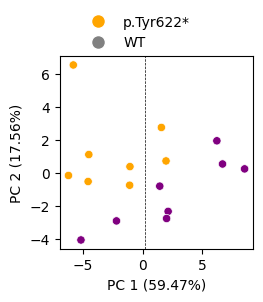

In [55]:
plot_pca(data_to_keep, names_no_blank, palette={'Y+H2O':'orange','Y+C' : 'purple'}, draw_median=True)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
        markerfacecolor='orange', markersize=10,linestyle='None', label='p.Tyr622*'),
    Line2D([0], [0], marker='o', markerfacecolor='grey',color='w',
        markersize=10, linestyle='None', label='WT')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.28), loc='upper center', frameon=False)


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.set_ylabel(df['class'][0], rotation=0, ha='right', va='center')
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

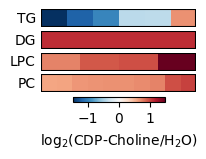

In [56]:
stats['class'] = [x.split('(')[0] for x in stats.index]
heatmap_data_list = [
    stats[stats['class'] == 'TG'],
    stats[stats['class'] == 'DG'],
    stats[stats['class'] == 'LPC'],
    stats[stats['class'] == 'PC']
]
cbar = plot_lfcs(heatmap_data_list, 'log2_fold_change')
cbar.set_label('log$_{2}$(CDP-Choline/H$_{2}$O)')

In [57]:
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)


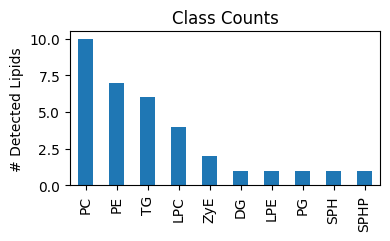

In [58]:
plt.figure(figsize=(4,2))
plot_class_counts(stats)

In [59]:
stats['unsaturations'][stats['class'] == 'TG'].nunique()

4

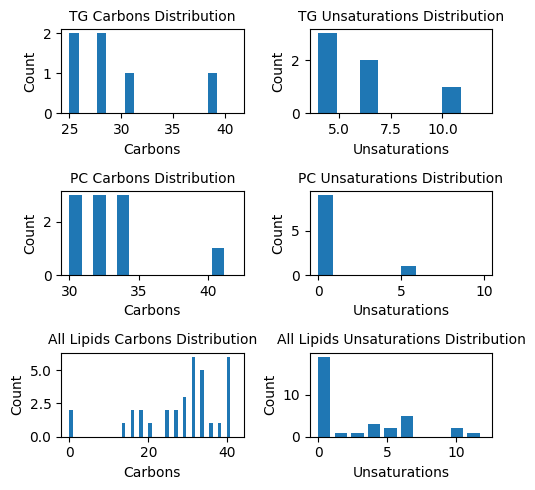

In [60]:
plot_carbon_distributions(stats)

In [61]:
names_no_blank

array(['Y+H2O', 'Y+H2O', 'Y+H2O', 'Y+H2O', 'Y+H2O', 'Y+H2O', 'Y+H2O',
       'Y+H2O', 'Y+C', 'Y+C', 'Y+C', 'Y+C', 'Y+C', 'Y+C', 'Y+C', 'Y+C'],
      dtype='<U6')

In [8]:
# by group stats
groups = [x.split('(')[0] for x in data_to_keep.index]
by_grp = data_to_keep.groupby(groups).sum()
by_grp_stats = return_stats(by_grp, names_no_blank, 'Y+H2O', 'Y+C', equal_var=True)

by_grp_stats['score'] = -1*np.log10(by_grp_stats['p_value']) * np.sign(by_grp_stats['log2_fold_change'])
by_grp_stats.sort_values(by='p_value')

,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,score
ZyE,-3.852787,0.001758,-0.918494,0.017579,-2.755015
TG,-2.812719,0.013830,-0.759341,0.069148,-1.859189
LPC,2.599169,0.021011,1.081977,0.070038,1.677547
PC,2.018864,0.063078,0.650901,0.140046,1.200124
PG,1.879898,0.081094,0.662034,0.140046,1.091010
PE,1.859976,0.084027,0.402516,0.140046,1.075579
DG,1.596703,0.132651,1.111260,0.189501,0.877290
SPH,-1.469606,0.163781,-0.846850,0.204726,-0.785737
LPE,1.163582,0.264042,0.623993,0.293380,0.578328
SPHP,-1.047392,0.312665,-2.697870,0.312665,-0.504920


In [9]:
# classify fatty acids in TGs
selected_rows_TG = data_to_keep[np.array(groups)=='TG']

carbon_counts_classified = np.array([classify_fatty_acid_length(count_carbons(x)/3) for x in selected_rows_TG.index])

by_grp = selected_rows_TG.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_no_blank, 'Y+H2O', 'Y+C')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
LCFA,-5.496511,0.000207,-1.215461,0.000414
MCFA,-1.412888,0.191502,-0.510080,0.191502


In [10]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['LCFA', 'MCFA'], dtype='<U4'), array([1, 5]))

In [11]:
# classify fatty acids in PCs
selected_rows_PC = data_to_keep[np.array(groups)=='PC']

carbon_counts_classified = np.array([classify_unsaturation(count_unsaturations(x)) for x in selected_rows_PC.index])

by_grp = selected_rows_PC.groupby(carbon_counts_classified).sum()
by_grp_stats = return_stats(by_grp, names_no_blank, 'Y+H2O', 'Y+C')
by_grp_stats



,t_stat,p_value,log2_fold_change,fdr_corrected_p_value
PUFA,2.310984,0.037245,0.657596,0.070242
UFA,1.994645,0.070242,0.650373,0.070242


In [12]:
np.unique(carbon_counts_classified, return_counts=True)

(array(['PUFA', 'UFA'], dtype='<U4'), array([1, 9]))